In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [6, 5]

In [2]:
pathw = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\winter_data_defined'
paths = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\summer_data_defined'

filename_s = glob.glob(paths + "\*.xls")
filename_w = glob.glob(pathw + "\*.xls")

df_s = pd.DataFrame()
df_w = pd.DataFrame()
df = [df_s, df_w]
filenames = [filename_s, filename_w]
#Merge all data files in df dataframe
for i in range(len(df)):
    for j in range(len(filenames[i])):
        data = pd.read_excel(filenames[i][j], 'A')              
        df[i] = pd.concat([df[i],data])
        
df_s = df[0] #summer data
df_w = df[1] #winter data

dc_s , dc_w = {}, {}
dc = [dc_s , dc_w]

for i in range(len(df)):
    for j in range(len(filenames[i])):
        dc[i][j] = df[i].iloc[361+1440*j:1081+1440*j,:]
        

        #Check mising values, and if there are NaN values, it will replaced by interpolating values (Missing data in 22/08/2007  )
for i in range(len(df)):
    for j in range(len(filenames)):
        if dc[i][j].isnull().sum().sum() != 0:   #check total no of NaN values
            dc[i][j] = dc[i][j].interpolate(method ='linear', limit_direction ='forward') 


#Add target variable for multiclass classifier (sequence acording to paper)
s = [3,6,0,5,0,4,1,2,7]    
w = [0,0,0,1,2,3,4,5,6,7]
fault_state = [s,w]
for i in range(len(df)):
    for j in range(len(fault_state[i])):
         
        dc[i][j].loc[:,'y']= fault_state[i][j]
        

In [3]:
filename_s

['E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070820.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070822.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070823.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070824.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070825.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070827.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070905.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined\\20070906.xls',
 'E:\\Prasad\\IITM\\ASHRAE DATA  acc to papers\\Undefined_state_data_ashrae\\summer_data_defined

In [4]:
# Collect only fault data from both seasons AHU A

fault_date_s = [0,1,3,5,6,7,8]   #locations of fault data files summer
fault_date_w = [3,4,5,6,7,8,9]   #locations of fault data files winter
fd = [fault_date_s,fault_date_w]

dc_fs, dc_fw = pd.DataFrame(), pd.DataFrame()
dc_f = [dc_fs, dc_fw]
for i in range(len(fd)):
    for j in fd[i]:
        data = dc[i][j]
        dc_f[i] = pd.concat([dc_f[i],data])
        
dc_fs = dc_f[0]
dc_fw = dc_f[1]

dc_fs = dc_fs.reset_index()
dc_fw = dc_fw.reset_index()
#Drop unnecessay column variables
dc_fs = dc_fs.drop(['index','DATE','TIME'], axis=1)  # Summer fault data
dc_fw = dc_fw.drop(['index','DATE','TIME'], axis=1)  # Winter fault data

In [5]:
dc_fs.head()

,SYS-CTL,RF-CTRL,ECONCTRL,ACCH-SEL,HWC-VLV,CHWC-VLV,EA-DMPR,RA-DMPR,OA-DMPR,SF-SST,...,CHWC_GPM,E_hcoil,E_ccoil,E_SF,E_RF,E_ZONE_I,E_ZONE_W,E_ZONE_S,E_ZONE_E,y
0,1,1,1,1,100.0,0.0,100.0,0.000,0.000,1,...,0.154,3.626,0.0,0.125,0.096,-0.012,0.0,0.000,0.0,3
1,1,1,1,1,100.0,0.0,100.0,0.000,0.000,1,...,0.154,-8.854,0.0,0.143,0.089,-0.012,0.0,0.000,0.0,3
2,1,1,1,1,100.0,0.0,100.0,5.890,5.890,1,...,0.154,0.000,0.0,0.225,0.108,-0.010,0.0,0.000,0.0,3
3,1,1,1,1,100.0,0.0,100.0,9.373,9.373,1,...,0.179,0.000,0.0,0.368,0.139,-0.010,0.0,0.000,0.0,3
4,1,1,1,1,100.0,0.0,100.0,14.160,14.160,1,...,0.134,0.000,0.0,0.518,0.159,-0.012,0.0,0.001,0.0,3


In [6]:
#Normal data from AHU B

df_sb = pd.DataFrame()
df_wb = pd.DataFrame()
df_b = [df_sb, df_wb]
s_n = [2,3,4]            #locations of normal data files summer
w_n = [0,1,2]            #locations of normal data files winter
n = [s_n,w_n]

#Merge all data files in df dataframe
for i in range(len(n)):
    for j in n[i]:
        data1 = pd.read_excel(filenames[i][j], 'B')              
        df_b[i] = pd.concat([df_b[i],data1])
        
df_sb = df_b[0]
df_wb = df_b[1]

dc_sb , dc_wb = {},{}
dcb = [dc_sb , dc_wb]

for i in range(len(df_b)):
    for j in range(len(s_n)):
        dcb[i][j] = df_b[i].iloc[381+1440*j:1081+1440*j,:]
        
        
#Check mising values, and if there are NaN values, it will replaced by interpolating values (Missing data in 22/08/2007  )
for i in range(len(df)):
    for j in range(len(s_n)):
        if dcb[i][j].isnull().sum().sum() != 0:   #check total no of NaN values
            dcb[i][j] = dcb[i][j].interpolate(method ='linear', limit_direction ='forward')  
            
#Add target variable for multiclass classifier (normal data - 0)
for i in range(len(dcb)):
    for j in range(3):
        dcb[i][j].loc[:,'y']= 0
        
        
        
data_s, data_w = pd.DataFrame(), pd.DataFrame()
data_ = [data_s, data_w]
for i in range(len(df_b)):
    for j in range(len(s_n)):
        data = dcb[i][j]
        data_[i] = pd.concat([data_[i], data] )  
        
data_s = data_[0]
data_w = data_[1]

data_s = data_s.reset_index()
data_w = data_w.reset_index()

#Drop unnecessay column variables
data_s = data_s.drop(['index','DATE','TIME'], axis=1) #summer normal data AHU B
data_w = data_w.drop(['index','DATE','TIME'], axis=1) #winter normal data AHU B  

In [7]:
# normal data for determing threshold of slope in summer  2007/09/04 14:00 - 18:00
train_ss_s = pd.read_excel(r"E:\Prasad\IITM\AHRAE-D-RP-1312-EXCEL DATA\Experiment\Fault test\2007summer\20070904-16.xls", 'A').iloc[841:1080]

# normal data for determing threshold of slope in winter  2008/02/17 14:00 - 18:00  
train_ss_w = pd.read_excel(r"E:\Prasad\IITM\AHRAE-D-RP-1312-EXCEL DATA\Experiment\Fault test\2008winter\20080217-19.xls", 'A').iloc[841:1080]

In [8]:
# Data preprocessing- steady state detection based on slope method described in paper

# Import steady state detection module developed according to papaer
from SSD import *

#summer steady state data
steady_st_data_sf = SSD(train_ss_s,dc_fs)  # Steady state fault data of summer
steady_st_data_sn = SSD(train_ss_s,data_s) # steady state normal data of summer

#winter steady state data
steady_st_data_wf = SSD(train_ss_w,dc_fw)  # Steady state fault data of winter
steady_st_data_wn = SSD(train_ss_w,data_w) # steady state normal data of winter

In [9]:
steady_st_data_sn

,SYS-CTL,RF-CTRL,ECONCTRL,ACCH-SEL,HWC-VLV,CHWC-VLV,EA-DMPR,RA-DMPR,OA-DMPR,SF-SST,...,CHWC_GPM,E_hcoil,E_ccoil,E_SF,E_RF,E_ZONE_I,E_ZONE_W,E_ZONE_S,E_ZONE_E,y
49,1.0,1.0,1.0,1.0,100.0,22.962,40.0,40.0,40.0,1.0,...,1.001,0.0,4.593,0.544,0.228,-0.005,0.0,-0.001,0.002,0.0
50,1.0,1.0,1.0,1.0,100.0,23.068,40.0,40.0,40.0,1.0,...,0.822,0.0,3.568,0.553,0.230,-0.006,0.0,-0.001,0.001,0.0
227,1.0,1.0,1.0,1.0,100.0,36.806,40.0,40.0,40.0,1.0,...,4.574,0.0,12.227,1.126,0.334,-0.005,0.0,0.000,0.000,0.0
228,1.0,1.0,1.0,1.0,100.0,36.671,40.0,40.0,40.0,1.0,...,4.531,0.0,12.311,1.123,0.335,-0.004,0.0,0.000,0.000,0.0
229,1.0,1.0,1.0,1.0,100.0,36.594,40.0,40.0,40.0,1.0,...,4.416,0.0,12.127,1.115,0.333,-0.004,0.0,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,1.0,1.0,1.0,1.0,100.0,54.523,40.0,40.0,40.0,1.0,...,6.675,0.0,16.165,1.706,0.440,-0.002,0.0,0.000,0.000,0.0
2096,1.0,1.0,1.0,1.0,100.0,50.585,40.0,40.0,40.0,1.0,...,6.773,0.0,16.342,1.696,0.433,-0.001,0.0,0.000,-0.001,0.0
2097,1.0,1.0,1.0,1.0,100.0,50.217,40.0,40.0,40.0,1.0,...,6.662,0.0,16.171,1.692,0.441,-0.002,0.0,0.000,-0.001,0.0
2098,1.0,1.0,1.0,1.0,100.0,49.877,40.0,40.0,40.0,1.0,...,6.723,0.0,16.320,1.692,0.439,-0.002,0.0,0.000,-0.001,0.0


In [10]:
# Input variables of model
input_var = ['E_hcoil','E_ccoil','SF-WAT','RF-WAT','SF-SPD','RF-SPD','SA-SP','SA-CFM','RA-CFM','OA-CFM','EA-DMPR','RA-DMPR','OA-DMPR']

steady_st_data_sf = steady_st_data_sf.reset_index()
steady_st_data_sf = steady_st_data_sf.drop(['index'], axis=1)

steady_st_data_wf = steady_st_data_wf.reset_index()
steady_st_data_wf = steady_st_data_wf.drop(['index'], axis=1)

steady_st_data_sn = steady_st_data_sn.reset_index()
steady_st_data_sn = steady_st_data_sn.drop(['index'], axis=1)

steady_st_data_wn = steady_st_data_wn.reset_index()
steady_st_data_wn = steady_st_data_wn.drop(['index'], axis=1)

In [11]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Normalize data between 0 and 1 using Minmaxscaler
from sklearn import preprocessing
mscale = preprocessing.MinMaxScaler()
scale = preprocessing.StandardScaler()

# summer data
Xns=steady_st_data_sn[input_var] # Features
Yns=steady_st_data_sn['y']  # Labels

Xfs=steady_st_data_sf[input_var] # Features
Yfs=steady_st_data_sf['y']  # Labels

# Split dataset into training set and test set- Normal data
X_trainns, X_valns, y_trainns, y_valns = train_test_split(Xns.values, Yns, test_size=0.2) # 80% training and 20% test
# Split dataset into training set and test set- Fault data
X_trainfs_, X_testfs, y_trainfs_, y_testfs = train_test_split(Xfs.values, Yfs, test_size=0.2) # splitting in train and test
# Split dataset into training set and validation set- Fault data
X_trainfs, X_valfs, y_trainfs, y_valfs = train_test_split(X_trainfs_, y_trainfs_, test_size=0.25) # splitting in train and validation test



x_trains = np.concatenate([X_trainns,X_trainfs])
y_trains = np.concatenate([y_trainns,y_trainfs])
x_vals = np.concatenate([X_valns,X_valfs])
y_vals = np.concatenate([y_valns,y_valfs])

scale.fit(x_trains)
x_trains = scale.transform(x_trains)
x_vals = scale.transform(x_vals)

from keras.utils.np_utils import to_categorical
y_trains = to_categorical(y_trains)
y_vals = to_categorical(y_vals)
y_testfs = to_categorical(y_testfs)

In [12]:
pd.DataFrame(scale.transform(x_vals))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,-1.317803,-2.290255,-2.446771,-6.773384,-3.888259,-13.335504,-4.032186,-5.738408,-3.298249,-2.942400,-11.979991,-8.742413
1,0.0,-1.300493,-2.290239,-2.446576,-6.766178,-3.884608,-4.740991,-4.032429,-5.738290,-3.304324,-2.942400,-11.979991,-8.742413
2,0.0,-1.335531,-2.290474,-2.448021,-6.789399,-3.895808,-6.290821,-4.032884,-5.739665,-3.305748,-2.942400,-11.979991,-8.742413
3,0.0,-1.276401,-2.290121,-2.445795,-6.756232,-3.879835,-6.854396,-4.032164,-5.737672,-3.303111,-2.942400,-11.979991,-8.742413
4,0.0,-1.253492,-2.289486,-2.443061,-6.715075,-3.859678,-2.627586,-4.030936,-5.735934,-3.291236,-2.942400,-11.979991,-8.742413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.0,-1.229456,-2.289727,-2.444737,-6.732812,-3.868445,-5.868140,-4.031363,-5.736923,-3.297793,-2.678013,-11.979991,-8.742413
390,0.0,-1.253325,-2.289521,-2.444502,-6.726428,-3.865307,-8.545120,-4.031108,-5.737101,-3.299901,-2.942400,-11.979991,-8.742413
391,0.0,-1.484568,-2.287442,-2.435829,-6.579882,-3.794383,-19.816613,-4.028441,-5.734101,-3.287947,-2.942400,-11.979991,-8.742413
392,0.0,-1.180784,-2.289100,-2.452238,-6.687264,-3.989027,-11.644780,-4.030582,-5.739899,-3.294096,-2.942400,-11.979991,-8.742413


In [13]:
x_trains.std(axis=0)

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
X_trainns.mean(axis=0)[12]

40.65573770491803

In [15]:
pd.DataFrame(y_vals)

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
389,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
391,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
392,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
array_sum = np.sum(x_trains)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [17]:
pd.DataFrame(x_vals)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.085290,-1.063184,-0.563465,-1.081962,-0.377855,0.218146,-1.022588,-0.527656,-0.550469,-0.269282,-0.056166,-0.272803
1,0.0,0.231975,-1.048899,-0.529650,-0.992080,-0.319330,0.942208,-1.172983,-0.483261,-1.551672,-0.269282,-0.056166,-0.272803
2,0.0,-0.064935,-1.260573,-0.779876,-1.281691,-0.498835,0.811639,-1.455025,-1.000023,-1.786277,-0.269282,-0.056166,-0.272803
3,0.0,0.436131,-0.942413,-0.394396,-0.868041,-0.242836,0.764160,-1.008659,-0.251177,-1.351715,-0.269282,-0.056166,-0.272803
4,0.0,0.630256,-0.369724,0.078997,-0.354728,0.080234,1.120256,-0.246890,0.402090,0.605168,-0.269282,-0.056166,-0.272803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.0,0.833940,-0.587388,-0.211148,-0.575945,-0.060275,0.847249,-0.512176,0.030340,-0.475321,3.713583,-0.056166,-0.272803
390,0.0,0.631672,-0.401631,-0.170559,-0.496326,-0.009986,0.621721,-0.353466,-0.036470,-0.822727,-0.269282,-0.056166,-0.272803
391,0.0,-1.327868,1.472824,1.331215,1.331380,1.126751,-0.327868,1.300025,1.091201,1.147202,-0.269282,-0.056166,-0.272803
392,0.0,1.246381,-0.022323,-1.509980,-0.007869,-1.992896,0.360584,-0.027262,-1.088048,0.133863,-0.269282,-0.056166,-0.272803


In [18]:
pd.DataFrame(X_trainns)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,13.315,1443.789,391.101,74.920,59.936,1.387,2219.386,2179.017,564.633,40.0,40.0,40.0
1,0.0,13.353,1121.776,330.211,70.854,56.679,1.410,1822.393,1937.598,313.065,40.0,40.0,40.0
2,0.0,12.118,1099.528,324.356,70.609,56.526,1.429,1780.826,1913.519,305.901,40.0,40.0,40.0
3,0.0,16.413,1740.042,441.452,79.053,63.221,1.406,2377.820,2324.195,661.556,40.0,40.0,40.0
4,0.0,11.048,964.868,295.082,67.878,54.300,1.406,1651.140,1815.507,254.343,40.0,40.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.0,13.053,1399.293,381.733,74.549,59.665,1.436,2148.835,2145.538,541.547,40.0,40.0,40.0
362,0.0,15.876,1614.749,420.375,77.269,61.818,1.398,2281.383,2234.839,620.999,40.0,40.0,40.0
363,0.0,14.500,1141.683,332.553,71.236,57.010,1.429,1803.745,1952.423,303.035,40.0,40.0,40.0
364,0.0,13.077,1461.354,391.101,74.894,59.866,1.372,2220.859,2190.180,567.520,40.0,40.0,40.0


In [19]:
# Data visualization 
import seaborn as sns

# Keras
import keras
from keras.models import Sequential
from keras import layers, losses
from keras.layers import Dense, Dropout, Concatenate, BatchNormalization
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K

# Classification Report
from sklearn.metrics import classification_report

In [20]:
input_data = keras.Input(shape=(13,)) ## Input layer
encoded = layers.Dense(300, activation='relu')(input_data) ## Encoder layer
encoded = keras.layers.BatchNormalization()(encoded)
encoded = keras.layers.Dropout(0.2)(encoded)
decoded = layers.Dense(13, activation='linear', name='cont_out')(encoded) ## Decoder layer
classified = layers.Dense(8, activation = 'linear',name='cat_out')(encoded)  ## Classification layer

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [22]:
autoencoder = keras.Model(input_data ,outputs= [decoded, classified])

#autoencoder.compile(optimizer='RMSprop', loss={'cont_out': 'mse', 
#                    'cat_out': 'categorical_crossentropy'},)
autoencoder.compile(optimizer='RMSprop', loss={'cont_out': 'mse', 
                    'cat_out': losses.CategoricalCrossentropy(from_logits=True)},)

history = autoencoder.fit(x_trains, {'cont_out': x_trains, 'cat_out': y_trains},
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_vals, {'cont_out': x_vals, 'cat_out': y_vals}),callbacks=[callback])

Epoch 1/200
10/10 [==============================] - 3s 71ms/step - loss: 2.0054 - cont_out_loss: 1.1113 - cat_out_loss: 0.8942 - val_loss: 2.0843 - val_cont_out_loss: 0.5724 - val_cat_out_loss: 1.5119
Epoch 2/200
10/10 [==============================] - 0s 17ms/step - loss: 0.7808 - cont_out_loss: 0.5420 - cat_out_loss: 0.2388 - val_loss: 1.8944 - val_cont_out_loss: 0.5493 - val_cat_out_loss: 1.3450
Epoch 3/200
10/10 [==============================] - 0s 17ms/step - loss: 0.6327 - cont_out_loss: 0.5072 - cat_out_loss: 0.1255 - val_loss: 1.7742 - val_cont_out_loss: 0.5287 - val_cat_out_loss: 1.2454
Epoch 4/200
10/10 [==============================] - 0s 15ms/step - loss: 0.5601 - cont_out_loss: 0.4690 - cat_out_loss: 0.0912 - val_loss: 1.6691 - val_cont_out_loss: 0.5257 - val_cat_out_loss: 1.1434
Epoch 5/200
10/10 [==============================] - 0s 16ms/step - loss: 0.5110 - cont_out_loss: 0.4456 - cat_out_loss: 0.0654 - val_loss: 1.5714 - val_cont_out_loss: 0.5105 - val_cat_out_los

10/10 [==============================] - 0s 16ms/step - loss: 0.0654 - cont_out_loss: 0.0636 - cat_out_loss: 0.0019 - val_loss: 0.0860 - val_cont_out_loss: 0.0656 - val_cat_out_loss: 0.0204
Epoch 42/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0694 - cont_out_loss: 0.0678 - cat_out_loss: 0.0016 - val_loss: 0.0936 - val_cont_out_loss: 0.0738 - val_cat_out_loss: 0.0198
Epoch 43/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0658 - cont_out_loss: 0.0647 - cat_out_loss: 0.0011 - val_loss: 0.0924 - val_cont_out_loss: 0.0751 - val_cat_out_loss: 0.0173
Epoch 44/200
10/10 [==============================] - 0s 14ms/step - loss: 0.0607 - cont_out_loss: 0.0599 - cat_out_loss: 8.2228e-04 - val_loss: 0.0726 - val_cont_out_loss: 0.0568 - val_cat_out_loss: 0.0158
Epoch 45/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0554 - cont_out_loss: 0.0548 - cat_out_loss: 5.8831e-04 - val_loss: 0.0678 - val_cont_out_loss: 0.0541 - val_cat_out_los

dict_keys(['loss', 'cont_out_loss', 'cat_out_loss', 'val_loss', 'val_cont_out_loss', 'val_cat_out_loss'])


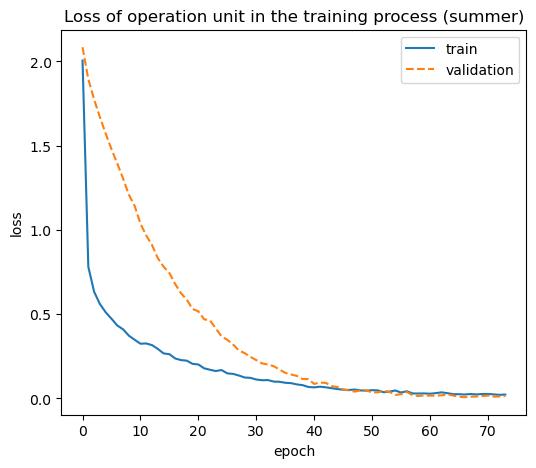

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Loss of operation unit in the training process (summer)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

13/13 [==============================] - 0s 3ms/step


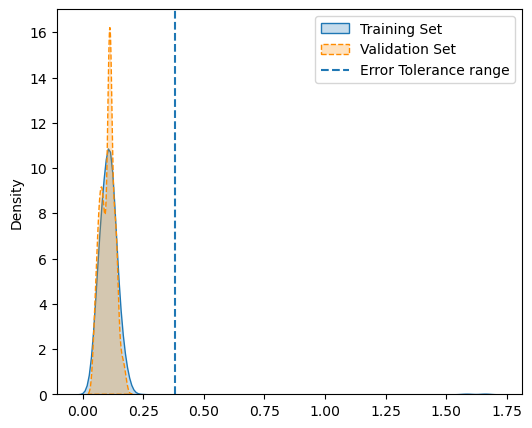

In [24]:
# Prediction of output with developed model
[recontructed_input_t,classification_t]= autoencoder.predict(x_trains)
[recontructed_input_v,classification_v]= autoencoder.predict(x_vals)

#classification_v = tf.nn.softmax(classification_v).numpy()

# Evaluation of recontruction error for both training and validation set
recontruct_error_t = tf.keras.losses.mse(recontructed_input_t, x_trains)
recontruct_error_t = np.sqrt(recontruct_error_t)
recontruct_error_v = tf.keras.losses.mse(recontructed_input_v, x_vals)
recontruct_error_v = np.sqrt(recontruct_error_v)

# Setting recontruction error threshold
recontruct_error_t_std = np.std(recontruct_error_t)
rec_err_thr = 3*recontruct_error_t_std + sum(recontruct_error_t)/len(recontruct_error_t)

# Plotting density plot for recontruction error for both training and validation set
fig = sns.kdeplot(recontruct_error_t, shade=True, label='Training Set')
fig = sns.kdeplot(recontruct_error_v, shade=True,color="darkorange", linestyle='--', label= 'Validation Set')
plt.axvline(x=rec_err_thr, linestyle='--', label= 'Error Tolerance range')
plt.legend()

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [26]:
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print("\nConfusion Matrix: \n",
        confusion_matrix(y_test, y_pred))
      
    print ("\nAccuracy : \n",
    accuracy_score(y_test,y_pred)*100)
      
    print("\nReport :\n ",
    classification_report(y_test, y_pred))

In [27]:
def classif_report(y_test, y_pred):
    a = len(y_pred)
    y_pred1 = tf.nn.softmax(y_pred).numpy()
    y_p = np.zeros(a)
    y_pv = np.zeros(a)
    y_pre = np.zeros((a,8))
    for i in range(a):
        for j in range(8):
            if y_pred1[i][j]>= 0.5:
                y_pre[i][j] = 1
            if y_pre[i][j] == 1:
                y_p[i] = j
            if y_test[i][j] == 1:
                y_pv[i] = j

    cal_accuracy(y_pv, y_p)
        

In [28]:
classification_v

array([[10.846728  , -1.9233935 , -2.145468  , ..., -4.505967  ,
        -1.3761398 , -1.7612497 ],
       [10.702277  , -5.799623  , -2.4824412 , ..., -3.305372  ,
        -4.3085394 , -1.0760322 ],
       [ 9.33709   , -5.4438744 , -1.7924647 , ..., -3.8635306 ,
        -2.6436741 ,  0.02279019],
       ...,
       [-4.3662443 , -0.16120452, -0.02052716, ...,  3.3214777 ,
        -2.5397105 ,  0.08546566],
       [-6.963337  ,  2.1429658 , -0.9596243 , ...,  1.2774017 ,
        13.410413  ,  2.1754084 ],
       [-7.6257133 ,  2.310184  , -0.89746255, ...,  2.4414365 ,
        13.421395  ,  1.9535918 ]], dtype=float32)

In [29]:
classif_report(y_vals,classification_v)


Confusion Matrix: 
 [[ 92   0   0   0   0   0   0   0]
 [  1  37   0   0   0   0   0   0]
 [  0   0  16   0   0   0   0   0]
 [  0   0   0  31   0   0   0   0]
 [  0   0   0   0 128   0   0   0]
 [  0   0   0   0   0   5   0   0]
 [  0   0   0   0   0   0  51   0]
 [  0   0   0   0   0   0   0  33]]

Accuracy : 
 99.74619289340102

Report :
                precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        92
         1.0       1.00      0.97      0.99        38
         2.0       1.00      1.00      1.00        16
         3.0       1.00      1.00      1.00        31
         4.0       1.00      1.00      1.00       128
         5.0       1.00      1.00      1.00         5
         6.0       1.00      1.00      1.00        51
         7.0       1.00      1.00      1.00        33

    accuracy                           1.00       394
   macro avg       1.00      1.00      1.00       394
weighted avg       1.00      1.00      1.00       394



In [30]:
from tensorflow.keras.utils import plot_model
#Model Details
autoencoder.summary()
keras.utils.plot_model(autoencoder, "output.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 300)          4200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 300)         1200        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 300)          0           ['batch_normalization[0][0]']

In [31]:
## Undefined state data collection for summer and winter

pathwu = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\test_set_undefined\winter'
pathsu = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\test_set_undefined\summer'

filename_su = glob.glob(pathsu + "\*.xls")
filename_wu = glob.glob(pathwu + "\*.xls")

df_su = pd.DataFrame()
df_wu = pd.DataFrame()
dfu = [df_su, df_wu]
filenamesu = [filename_su, filename_wu]
#Merge all data files in df dataframe
for i in range(len(dfu)):
    for j in range(len(filenamesu[i])):
        datau = pd.read_excel(filenamesu[i][j], 'A')              
        dfu[i] = pd.concat([dfu[i],datau])
        
df_su = dfu[0] #summer data
df_wu = dfu[1] #winter data

dc_su , dc_wu = {}, {}
dcu = [dc_su , dc_wu]

for i in range(len(dfu)):
    for j in range(len(filenamesu[i])):
        dcu[i][j] = dfu[i].iloc[361+1440*j:1081+1440*j,:]
        

        #Check mising values, and if there are NaN values, it will replaced by interpolating values (Missing data in 22/08/2007  )
for i in range(len(dfu)):
    for j in range(len(filenamesu)):
        if dcu[i][j].isnull().sum().sum() != 0:   #check total no of NaN values
            dcu[i][j] = dc[i][j].interpolate(method ='linear', limit_direction ='forward') 
            

In [32]:
dc_su

{0:          DATE  TIME  SYS-CTL  RF-CTRL  ECONCTRL  ACCH-SEL  HWC-VLV  CHWC-VLV  \
 361   8212007   601        1        1         1         1    100.0       0.0   
 362   8212007   602        1        1         1         1    100.0       0.0   
 363   8212007   603        1        1         1         1    100.0       0.0   
 364   8212007   604        1        1         1         1    100.0       0.0   
 365   8212007   605        1        1         1         1    100.0       0.0   
 ...       ...   ...      ...      ...       ...       ...      ...       ...   
 1076  8212007  1756        1        1         1         1    100.0     100.0   
 1077  8212007  1757        1        1         1         1    100.0     100.0   
 1078  8212007  1758        1        1         1         1    100.0     100.0   
 1079  8212007  1759        1        1         1         1    100.0     100.0   
 1080  8212007  1800        0        1         1         1    100.0     100.0   
 
       EA-DMPR  RA-DMPR

In [33]:
# Collect only undefined data from both seasons AHU A

fault_date_su = [0,1,2,4,5,6,7,8,9,10,15] #locations of fault data files summer
ys = [11,12,13,14,15,16,17,18,19,20,21]
fault_date_wu = [3,4,9,10,11]   #locations of fault data files winter
yw = [11,12,13,14,15]
fd = [fault_date_su,fault_date_wu]
yu = [ys,yw]
dc_fsu, dc_fwu = pd.DataFrame(), pd.DataFrame()
dc_fu = [dc_fsu, dc_fwu]
for i in range(len(fd)):
    for j in range(len(fd[i])):
        #dcu[i][fd[i][j]].loc[:,'y'] = yu[i][yu[i][j]]
        data = dcu[i][fd[i][j]]
        dc_fu[i] = pd.concat([dc_fu[i],data])
        
dc_fsu = dc_fu[0]
dc_fwu = dc_fu[1]

dc_fsu = dc_fsu.reset_index()
dc_fwu = dc_fwu.reset_index()
#Drop unnecessay column variables
#dc_fsu = dc_fsu.drop(['index','DATE','TIME'], axis=1)  # Summer fault data
dc_fwu = dc_fwu.drop(['index','DATE','TIME'], axis=1)  # Winter fault data

In [34]:
yu[1][3]

14

In [35]:
def evaluate_undefined(x_unds):
    a = len(x_unds)
    st_datas = SSD(train_ss_s,x_unds)
    st_datas = st_datas[input_var]
    st_datas = st_datas.to_numpy()
    st_datas = scale.transform(st_datas)
    #
    
    [recontructed_input_te,classification_te]= autoencoder.predict(st_datas)
    recontruct_error_v = tf.keras.losses.mse(recontructed_input_te, st_datas)
    recontruct_error_v = np.sqrt(recontruct_error_v)
    
    classification_te = tf.nn.softmax(classification_te).numpy()
    y=0
    for i in range(len(st_datas)):
        
        if recontruct_error_v[i]>=rec_err_thr:
            y += 1
    sensitivity = (y/len(st_datas))          
    return sensitivity

In [36]:
len(dc_fsu)

7920

In [37]:
evaluate_undefined(dc_fsu.iloc[2160:2880])

9/9 [==============================] - 0s 7ms/step


0.9715302491103203

In [38]:
X_testfs

array([[   0.   ,    0.   , 3362.811, ...,   40.   ,   40.   ,   40.   ],
       [   0.   ,   18.175, 1512.152, ...,  100.   ,   40.   ,   40.   ],
       [   0.   ,    0.   , 3244.51 , ...,   40.   ,   40.   ,   40.   ],
       ...,
       [   0.   ,   19.153, 1419.619, ...,   40.   ,   40.   ,   55.   ],
       [   0.   ,    0.   , 3210.542, ...,   40.   ,   40.   ,   40.   ],
       [   0.   ,   19.993, 1597.657, ...,   40.   ,   40.   ,   45.   ]])

In [39]:
X_testfs = scale.transform(X_testfs)

In [40]:
[recontructed_input_te,classification_te]= autoencoder.predict(X_testfs)

10/10 [==============================] - 0s 2ms/step


In [41]:
classif_report(y_testfs,classification_te)


Confusion Matrix: 
 [[ 43   0   0   0   0   0   0]
 [  0  14   0   0   0   0   0]
 [  0   0  28   0   0   0   0]
 [  0   0   0 133   0   0   0]
 [  0   0   0   0   5   0   0]
 [  0   0   0   0   0  58   0]
 [  0   0   0   0   0   0  21]]

Accuracy : 
 100.0

Report :
                precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        43
         2.0       1.00      1.00      1.00        14
         3.0       1.00      1.00      1.00        28
         4.0       1.00      1.00      1.00       133
         5.0       1.00      1.00      1.00         5
         6.0       1.00      1.00      1.00        58
         7.0       1.00      1.00      1.00        21

    accuracy                           1.00       302
   macro avg       1.00      1.00      1.00       302
weighted avg       1.00      1.00      1.00       302



In [42]:
# Evaluation of search performance of Undefined state
s = np.zeros(11)
for i in range(11):
    
    a = pd.DataFrame()
    a = dc_fsu.iloc[720*i:720*(i+1)]
    s[i] = evaluate_undefined(a)
    

6/6 [==============================] - 0s 4ms/step


In [43]:
s
ss =[s[2],s[0],s[7],s[8],s[6],s[9],s[3],s[4],s[5],s[1],s[10]]
ss

[1.0,
 0.0,
 0.3771626297577855,
 1.0,
 0.9881422924901185,
 1.0,
 0.9715302491103203,
 1.0,
 1.0,
 1.0,
 0.01675977653631285]

In [44]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

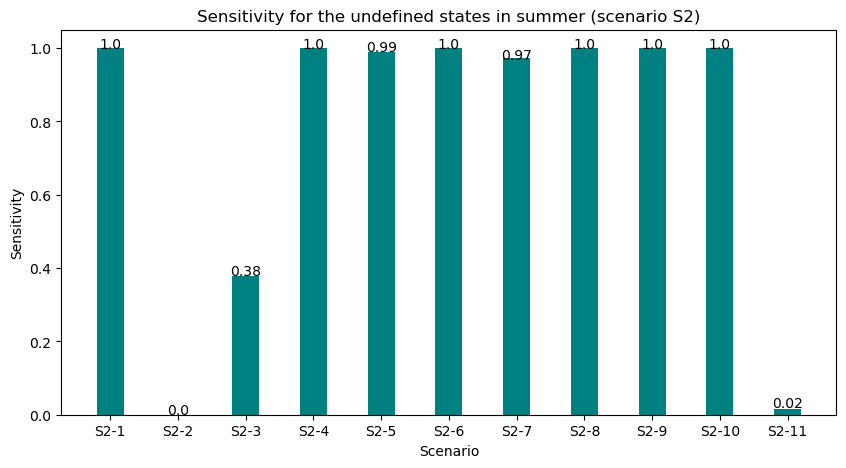

In [45]:
fig = plt.figure(figsize = (10, 5))
S = ['S2-1','S2-2','S2-3','S2-4','S2-5','S2-6','S2-7','S2-8','S2-9','S2-10','S2-11']
# creating the bar plot
plt.bar(S, ss, width = 0.4,color='teal')
addlabels(S, np.round(ss,2)) 
plt.xlabel("Scenario")
plt.ylabel("Sensitivity")
plt.title("Sensitivity for the undefined states in summer (scenario S2)")
plt.show()